In [1]:
import sys
sys.path.append('../..')
from hamp_pred.src.predictor import Predictor
from hamp_pred.src.predictor_config import DEFAULT_CONF, PredictionConfig,SEQ_ENCODING_EXTERNAL
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO
import tensorflow as tf
from hamp_pred.external.SequenceEncoding.SequenceEncoding import SequenceEncoding, get_dict
from hamp_pred.src.input_prep.encode import OneHotEncoderSeq, RadianEncoder, MixedEncoder, MultiEncoder
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper, BaseLinearWrapper
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from hamp_pred.src.output_analysis.visual import reg_plot
from keras.utils.vis_utils import plot_model
from Bio.PDB.PDBParser import PDBParser
import os
import matplotlib.pyplot as plt

2023-04-11 20:29:42.343854: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 20:29:42.476415: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-11 20:29:43.046553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-11 20:29:43.046639: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Prepare data

In [2]:
DATA_DIR = '../../data/input'

# data set contains train and validation sets
# the val set is used for eraly stopping 
data = f'{DATA_DIR}/af_clean_model_train_val.p'
data = pd.read_pickle(data)
data['n_seq'] = data['n_seq'].apply(lambda x: x[1:-1])
data['c_seq'] = data['c_seq'].apply(lambda x: x[1:-1])
data['train_seq'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
assert all(data['train_seq'].str.len() == 22)

# separate test set used to pick the best model
data_val = f'{DATA_DIR}/af_clean_model_test.p'
data_val = pd.read_pickle(data_val)


In [3]:
data['class'].value_counts()

train    3978
val       497
Name: class, dtype: int64

In [4]:
data_val['class'].value_counts()

val    497
Name: class, dtype: int64

## Train and validate

In [5]:
def get_rmse(val, mod):
    seqs = list(val.train_seq)
    tr=[]
    for n,r in val.iterrows():
        tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
    res = mod.predict(seqs)
    pr = []
    for n,r in res.iterrows():
        pr.append(np.mean(r['N_pred'])/2)
        
    return np.mean((np.array(tr)-np.array(pr)) **2 ) ** 0.5

In [6]:
def train(data, conf, version):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_rot', config=conf, version=version)
    trained = mod.train(data)
    return mod, trained

def get_mod(conf=None, version=None):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_rot', config=conf, version=version)
    return mod
    

In [7]:
def opt_conf(data, data_val, tune=False):
    
    # data: train and val (val for the eraly stopping)
    # data_val: val (val for picking the best model)
    
    results = {}

    # parameters grid
    kernels = [(3, 5, 7)]
    layers = [13, 5]
    lstm = [1, 2]
    dense = [1, 3]
    
    for kern in kernels:
        for l in layers:
            for ls in lstm:
                for d in dense:
                    model_config = {
                        'activation': 'tanh',
                        'norm': True,
                        'n_layers': l,
                        'kernel_sizes': kern,
                        'lstm': ls,
                        'dense': d,
                        'reshape_out': False,
                        'epochs': 100
                    }
                    version = '_'.join([str(x) for x in ["_".join([str(i) for i in kern]), l, ls, d]])
                    if tune:
                        mod, trained = train(data, model_config, version)
                    else:
                        mod = get_mod(model_config, version)
                        
                    results[version] = get_rmse(data_val, mod)
    return results
        

## Tune hiperparameters

In [10]:
res = opt_conf(data, data_val, tune=True)  

2023-04-11 18:19:41.197582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 18:19:41.769509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7380 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/100


2023-04-11 18:19:45.662264: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2023-04-11 18:19:45.900596: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 18:19:45.901331: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 18:19:45.901383: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-11 18:19:45.902160: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 18:19:45.902295: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


63/63 [==============================] - 6s 88ms/sample - loss: 0.0374 - mae: 0.1125 - val_loss: 0.0324 - val_mae: 0.1197 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 1s 15ms/sample - loss: 0.0189 - mae: 0.0850 - val_loss: 0.0300 - val_mae: 0.1172 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 1s 16ms/sample - loss: 0.0158 - mae: 0.0775 - val_loss: 0.0280 - val_mae: 0.1180 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 1s 15ms/sample - loss: 0.0126 - mae: 0.0700 - val_loss: 0.0189 - val_mae: 0.0917 - lr: 0.0010
Epoch 5/100
63/63 [==============================] - 1s 16ms/sample - loss: 0.0102 - mae: 0.0638 - val_loss: 0.0169 - val_mae: 0.0842 - lr: 0.0010
Epoch 6/100
63/63 [==============================] - 1s 16ms/sample - loss: 0.0086 - mae: 0.0597 - val_loss: 0.0167 - val_mae: 0.0835 - lr: 0.0010
Epoch 7/100
63/63 [==============================] - 1s 13ms/sample - loss: 0.0072 - mae: 0.0552 - val_loss: 0.0180 - val_mae: 0.0

63/63 [==============================] - 1s 14ms/sample - loss: 0.0019 - mae: 0.0291 - val_loss: 0.0162 - val_mae: 0.0765 - lr: 0.0010
Epoch 18/100
63/63 [==============================] - 1s 16ms/sample - loss: 0.0018 - mae: 0.0285 - val_loss: 0.0153 - val_mae: 0.0750 - lr: 0.0010
Epoch 19/100
63/63 [==============================] - 1s 14ms/sample - loss: 0.0016 - mae: 0.0273 - val_loss: 0.0160 - val_mae: 0.0764 - lr: 0.0010
Epoch 20/100
63/63 [==============================] - 1s 14ms/sample - loss: 0.0016 - mae: 0.0268 - val_loss: 0.0169 - val_mae: 0.0786 - lr: 0.0010
Epoch 21/100
63/63 [==============================] - 1s 14ms/sample - loss: 0.0021 - mae: 0.0303 - val_loss: 0.0164 - val_mae: 0.0755 - lr: 0.0010
Epoch 22/100
63/63 [==============================] - 1s 14ms/sample - loss: 0.0016 - mae: 0.0267 - val_loss: 0.0167 - val_mae: 0.0778 - lr: 0.0010
Epoch 23/100
 0/63 [..............................] - ETA: 0s - loss: 0.0013 - mae: 0.0244
Epoch 23: ReduceLROnPlateau reduci

63/63 [==============================] - 1s 17ms/sample - loss: 6.3217e-04 - mae: 0.0173 - val_loss: 0.0150 - val_mae: 0.0738 - lr: 1.0000e-05
Epoch 34/100
63/63 [==============================] - 1s 17ms/sample - loss: 6.2687e-04 - mae: 0.0172 - val_loss: 0.0150 - val_mae: 0.0738 - lr: 1.0000e-05
Epoch 35/100
63/63 [==============================] - 1s 17ms/sample - loss: 6.2741e-04 - mae: 0.0172 - val_loss: 0.0150 - val_mae: 0.0738 - lr: 1.0000e-05
Epoch 36/100
 0/63 [..............................] - ETA: 0s - loss: 6.2354e-04 - mae: 0.0171
Epoch 36: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
63/63 [==============================] - 1s 17ms/sample - loss: 6.2465e-04 - mae: 0.0172 - val_loss: 0.0150 - val_mae: 0.0738 - lr: 1.0000e-05
Epoch 37/100
63/63 [==============================] - 1s 17ms/sample - loss: 6.2202e-04 - mae: 0.0171 - val_loss: 0.0150 - val_mae: 0.0738 - lr: 1.0000e-06
Epoch 38/100
1/1 [==============================] - 1s 1s/step
Epoch 1/10

 0/63 [..............................] - ETA: 0s - loss: 3.5120e-04 - mae: 0.0128
Epoch 45: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
63/63 [==============================] - 1s 18ms/sample - loss: 3.5204e-04 - mae: 0.0128 - val_loss: 0.0154 - val_mae: 0.0744 - lr: 1.0000e-05
Epoch 46/100
63/63 [==============================] - 1s 18ms/sample - loss: 3.5009e-04 - mae: 0.0128 - val_loss: 0.0154 - val_mae: 0.0744 - lr: 1.0000e-06
Epoch 47/100
63/63 [==============================] - 1s 18ms/sample - loss: 3.5150e-04 - mae: 0.0128 - val_loss: 0.0154 - val_mae: 0.0744 - lr: 1.0000e-06
Epoch 48/100
63/63 [==============================] - 1s 19ms/sample - loss: 3.4865e-04 - mae: 0.0127 - val_loss: 0.0154 - val_mae: 0.0744 - lr: 1.0000e-06
Epoch 49/100
63/63 [==============================] - 1s 18ms/sample - loss: 3.5031e-04 - mae: 0.0128 - val_loss: 0.0154 - val_mae: 0.0744 - lr: 1.0000e-06
Epoch 50/100
63/63 [==============================] - 1s 18ms/sample - lo

Epoch 41/100
 0/63 [..............................] - ETA: 0s - loss: 4.0454e-04 - mae: 0.0146
Epoch 41: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
63/63 [==============================] - 1s 20ms/sample - loss: 4.0328e-04 - mae: 0.0146 - val_loss: 0.0138 - val_mae: 0.0695 - lr: 1.0000e-05
Epoch 42/100
63/63 [==============================] - 1s 20ms/sample - loss: 4.1487e-04 - mae: 0.0148 - val_loss: 0.0138 - val_mae: 0.0695 - lr: 1.0000e-06
Epoch 43/100
1/1 [==============================] - 1s 762ms/step
Epoch 1/100
63/63 [==============================] - 6s 96ms/sample - loss: 0.0379 - mae: 0.1119 - val_loss: 0.0316 - val_mae: 0.1165 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 1s 24ms/sample - loss: 0.0154 - mae: 0.0761 - val_loss: 0.0265 - val_mae: 0.1063 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 1s 24ms/sample - loss: 0.0117 - mae: 0.0678 - val_loss: 0.0150 - val_mae: 0.0769 - lr: 0.0010
Epoch 4/100
63/63 [==

63/63 [==============================] - 1s 21ms/sample - loss: 3.1788e-04 - mae: 0.0127 - val_loss: 0.0135 - val_mae: 0.0691 - lr: 1.0000e-05
Epoch 44/100
 0/63 [..............................] - ETA: 0s - loss: 3.0302e-04 - mae: 0.0124
Epoch 44: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
63/63 [==============================] - 1s 21ms/sample - loss: 3.0492e-04 - mae: 0.0124 - val_loss: 0.0135 - val_mae: 0.0691 - lr: 1.0000e-05
Epoch 45/100
63/63 [==============================] - 1s 21ms/sample - loss: 3.1374e-04 - mae: 0.0126 - val_loss: 0.0135 - val_mae: 0.0691 - lr: 1.0000e-06
Epoch 46/100
63/63 [==============================] - 1s 21ms/sample - loss: 2.8076e-04 - mae: 0.0120 - val_loss: 0.0135 - val_mae: 0.0691 - lr: 1.0000e-06
Epoch 47/100
63/63 [==============================] - 1s 21ms/sample - loss: 2.9942e-04 - mae: 0.0123 - val_loss: 0.0135 - val_mae: 0.0691 - lr: 1.0000e-06
Epoch 48/100
1/1 [==============================] - 1s 786ms/step
Epoch 1

63/63 [==============================] - 2s 29ms/sample - loss: 0.0144 - mae: 0.0734 - val_loss: 0.0194 - val_mae: 0.0889 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 2s 25ms/sample - loss: 0.0115 - mae: 0.0671 - val_loss: 0.0226 - val_mae: 0.0982 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 2s 29ms/sample - loss: 0.0094 - mae: 0.0640 - val_loss: 0.0150 - val_mae: 0.0768 - lr: 0.0010
Epoch 5/100
63/63 [==============================] - 2s 26ms/sample - loss: 0.0065 - mae: 0.0538 - val_loss: 0.0154 - val_mae: 0.0773 - lr: 0.0010
Epoch 6/100
63/63 [==============================] - 2s 25ms/sample - loss: 0.0048 - mae: 0.0463 - val_loss: 0.0166 - val_mae: 0.0774 - lr: 0.0010
Epoch 7/100
63/63 [==============================] - 2s 25ms/sample - loss: 0.0042 - mae: 0.0437 - val_loss: 0.0156 - val_mae: 0.0767 - lr: 0.0010
Epoch 8/100
63/63 [==============================] - 2s 25ms/sample - loss: 0.0039 - mae: 0.0422 - val_loss: 0.0153 - val_mae: 0.0

63/63 [==============================] - 2s 30ms/sample - loss: 0.0020 - mae: 0.0303 - val_loss: 0.0141 - val_mae: 0.0712 - lr: 0.0010
Epoch 16/100
63/63 [==============================] - 2s 26ms/sample - loss: 0.0018 - mae: 0.0291 - val_loss: 0.0160 - val_mae: 0.0761 - lr: 0.0010
Epoch 17/100
63/63 [==============================] - 2s 26ms/sample - loss: 0.0017 - mae: 0.0285 - val_loss: 0.0142 - val_mae: 0.0717 - lr: 0.0010
Epoch 18/100
63/63 [==============================] - 2s 27ms/sample - loss: 0.0015 - mae: 0.0266 - val_loss: 0.0153 - val_mae: 0.0742 - lr: 0.0010
Epoch 19/100
63/63 [==============================] - 2s 26ms/sample - loss: 0.0017 - mae: 0.0285 - val_loss: 0.0143 - val_mae: 0.0715 - lr: 0.0010
Epoch 20/100
63/63 [==============================] - 2s 30ms/sample - loss: 0.0016 - mae: 0.0271 - val_loss: 0.0141 - val_mae: 0.0718 - lr: 0.0010
Epoch 21/100
63/63 [==============================] - 2s 27ms/sample - loss: 0.0015 - mae: 0.0261 - val_loss: 0.0144 - val_ma

Epoch 20/100
 0/63 [..............................] - ETA: 0s - loss: 0.0019 - mae: 0.0297
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
63/63 [==============================] - 2s 28ms/sample - loss: 0.0019 - mae: 0.0297 - val_loss: 0.0147 - val_mae: 0.0724 - lr: 0.0010
Epoch 21/100
63/63 [==============================] - 2s 31ms/sample - loss: 0.0011 - mae: 0.0227 - val_loss: 0.0140 - val_mae: 0.0703 - lr: 1.0000e-04
Epoch 22/100
63/63 [==============================] - 2s 31ms/sample - loss: 8.0462e-04 - mae: 0.0192 - val_loss: 0.0138 - val_mae: 0.0693 - lr: 1.0000e-04
Epoch 23/100
63/63 [==============================] - 2s 31ms/sample - loss: 7.4461e-04 - mae: 0.0185 - val_loss: 0.0138 - val_mae: 0.0697 - lr: 1.0000e-04
Epoch 24/100
63/63 [==============================] - 2s 27ms/sample - loss: 7.3978e-04 - mae: 0.0186 - val_loss: 0.0139 - val_mae: 0.0698 - lr: 1.0000e-04
Epoch 25/100
63/63 [==============================] - 2s 28ms/sample - loss:

Epoch 27/100
63/63 [==============================] - 2s 31ms/sample - loss: 8.5974e-04 - mae: 0.0199 - val_loss: 0.0138 - val_mae: 0.0685 - lr: 1.0000e-04
Epoch 28/100
63/63 [==============================] - 2s 30ms/sample - loss: 7.2179e-04 - mae: 0.0184 - val_loss: 0.0138 - val_mae: 0.0684 - lr: 1.0000e-04
Epoch 29/100
63/63 [==============================] - 2s 31ms/sample - loss: 6.1411e-04 - mae: 0.0171 - val_loss: 0.0138 - val_mae: 0.0683 - lr: 1.0000e-04
Epoch 30/100
63/63 [==============================] - 2s 31ms/sample - loss: 5.2394e-04 - mae: 0.0159 - val_loss: 0.0138 - val_mae: 0.0687 - lr: 1.0000e-04
Epoch 31/100
63/63 [==============================] - 2s 30ms/sample - loss: 5.3494e-04 - mae: 0.0161 - val_loss: 0.0137 - val_mae: 0.0683 - lr: 1.0000e-04
Epoch 32/100
63/63 [==============================] - 2s 30ms/sample - loss: 4.5078e-04 - mae: 0.0148 - val_loss: 0.0137 - val_mae: 0.0681 - lr: 1.0000e-04
Epoch 33/100
 0/63 [..............................] - ETA: 0s - 

1/1 [==============================] - 1s 1s/step


In [11]:
# kern, layers, lstm, dense
for pos, (k, v) in enumerate(sorted(res.items(), key=lambda item: item[1])):
    print(pos+1, k, round(v, 2))

1 3_5_7_5_2_3 4.19
2 3_5_7_5_1_1 4.24
3 3_5_7_3_1_1 4.24
4 3_5_7_3_1_3 4.26
5 3_5_7_3_2_1 4.26
6 3_5_7_5_1_3 4.33
7 3_5_7_5_2_1 4.34
8 3_5_7_1_2_3 4.36
9 3_5_7_3_2_3 4.43
10 3_5_7_1_2_1 4.48
11 3_5_7_1_1_3 4.51
12 3_5_7_1_1_1 4.52


## Best Config

In [24]:
model_conf = model_config = {
    'kernel_sizes': (3, 5, 7),
    'n_layers': 1,
    'lstm': 1,
    'dense': 1,
    'activation': 'tanh',
    'norm': True,
    'reshape_out': False,
    'epochs': 100
}
mod = get_mod(conf=model_conf, version='3_5_7_1_1_1')

# PDB set performance

In [25]:
test_data = pd.read_pickle(f'{DATA_DIR}/pdb_measure.p')

In [26]:
test_data = pd.read_pickle(os.path.join(DATA_DIR, 'pdb_measure.p'))
test_data = test_data[~test_data.mutant]
test_data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq', 'n_list':'n_crick_mut', 'c_list':'c_crick_mut'}, inplace=True)
test_data['n_seq'] = test_data['n_seq'].apply(lambda x: x[1:-1])
test_data['c_seq'] = test_data['c_seq'].apply(lambda x: x[1:-1])
test_data['train_seq'] = test_data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
len(test_data)

11

In [27]:
seq = []
tr = []
for n,r in test_data.iterrows():
    seq.append(r['n_seq'] + r['c_seq'])
    tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
res = mod.predict(seq)
pr = []
for n,r in res.iterrows():
    pr.append(np.mean(r['N_pred'])/2)

1/1 [==============================] - 1s 650ms/step


Text(0.5, 1.0, 'HAMPpred model #1')

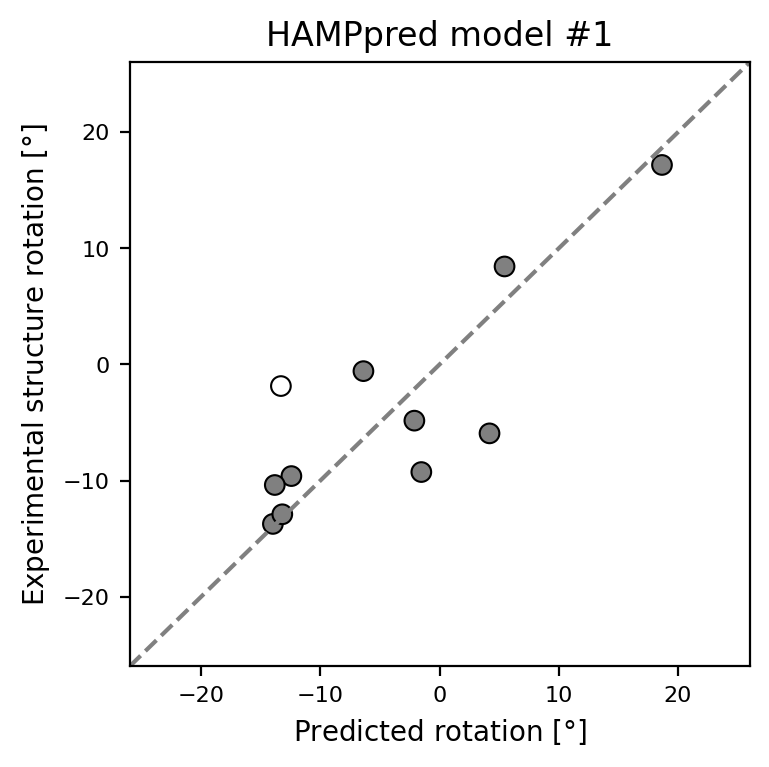

In [28]:
title_font_size = 12
label_font_size = 10
tick_font_size = 8

fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=200)

colors = ['white' if i=='1_2l7i.pdb' else 'grey' for i in test_data.index]

ax.scatter(pr, tr, color=colors, lw=0.75, edgecolors='k', s=50)

ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')

ax.set_xlabel(r'Predicted rotation [$\degree$]', size=label_font_size)
ax.set_ylabel(r'Experimental structure rotation [$\degree$]', size=label_font_size)

ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
ax.set_title("HAMPpred model #1", size=title_font_size)

In [29]:
np.mean((np.asarray(tr)-np.asarray(pr)) **2 ) ** 0.5

5.764317947471356

In [14]:
plt.plot(trained.history.history['mae'])
plt.plot(trained.history.history['val_mae'])
plt.title('model absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: name 'trained' is not defined

In [ ]:
plt.plot(trained.history.history['loss'])
plt.plot(trained.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Alpha fold test set results 

In [15]:
af_test_results = mod.predict(val, is_test=True)

NameError: name 'val' is not defined

In [16]:
reg_plot(af_test_results['true_mean_rot'], af_test_results['pred_mean_rot'], title='Prediction for af2 test set', ylabel='PDB Structure')

NameError: name 'af_test_results' is not defined

## Validation RMSE per position

In [17]:
pdb_test_results['mse_pos'] ** 0.5

NameError: name 'pdb_test_results' is not defined

## RMSE on AF2 test set

In [18]:
pdb_test_results['mse_seq'] ** 0.5

NameError: name 'pdb_test_results' is not defined

## Test on PDB

11

2023-04-11 10:52:42.116257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 10:52:42.692643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7380 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/users/sdunin/calc/HAMPpred/data/output/weights/hamp_rot/(3, 5, 7)_3_18_1/base_convolutional.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Text(0.5, 1.0, 'HAMPpred model #1')

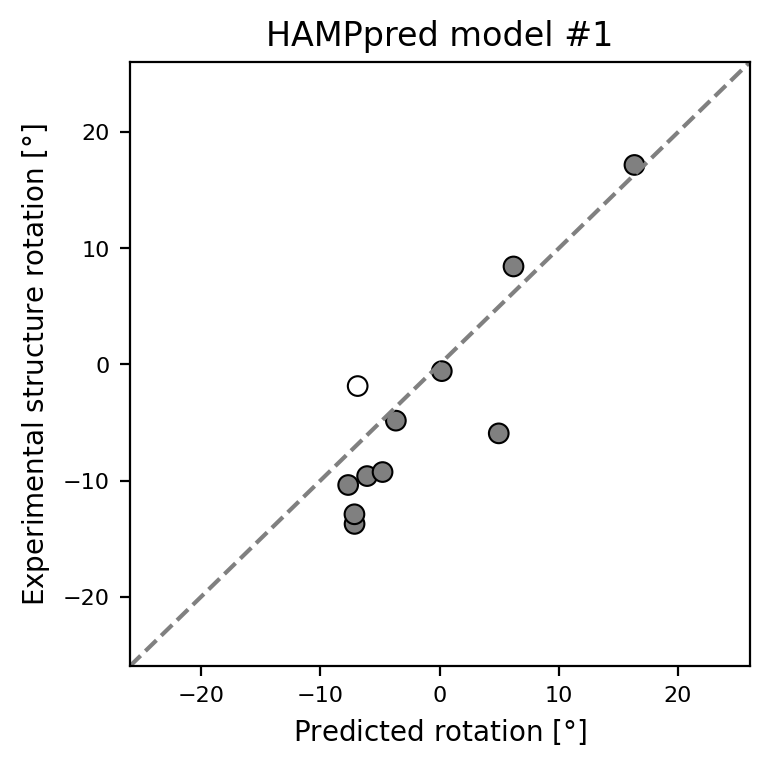

## RMSE on PDB test set

4.9378642788807685

## Validation MSE per position

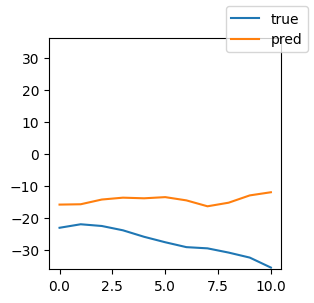

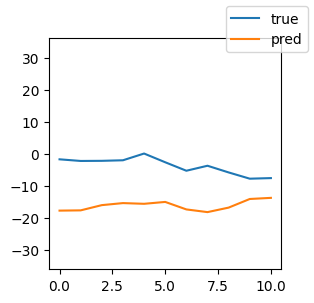

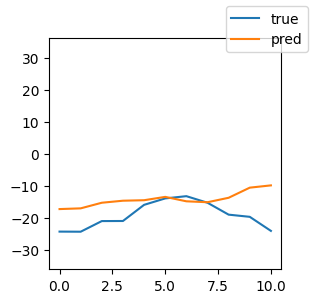

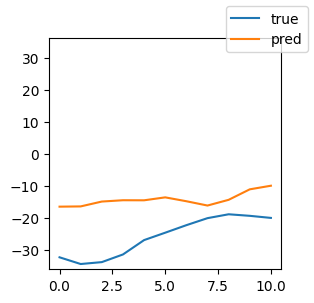

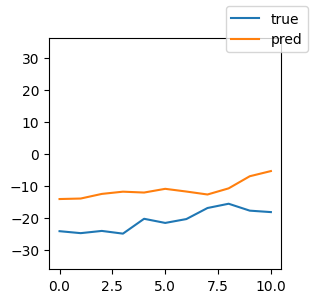

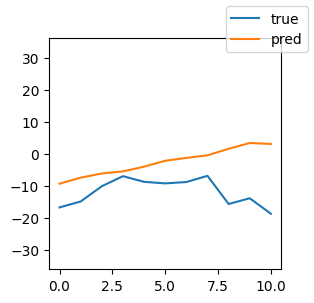

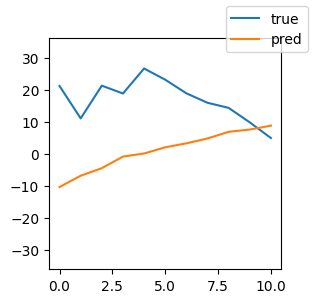

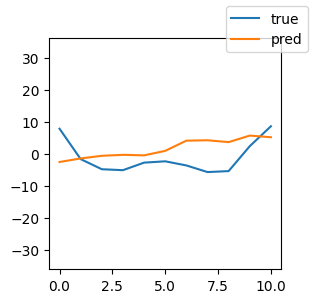

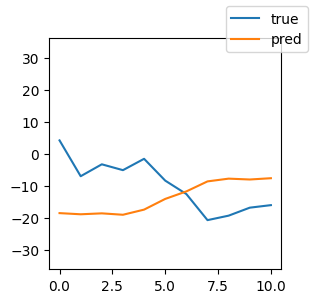

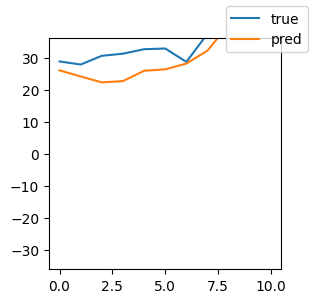

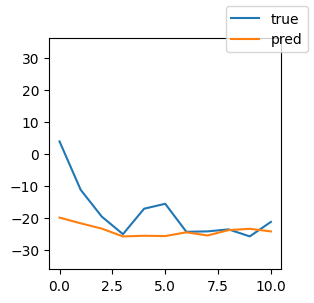

In [19]:
for i in range(len(test_data)):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=100)
    r = test_data.iloc[i]
    tr = (r['rot'][0::2] + r['rot'][1::2]) / 2
    pred = res.iloc[i]['N_pred']
    ax.plot(tr, label='true')
    ax.plot(pred, label='pred')
    ax.set_ylim(-36, 36)
    fig.legend(); pass